<a href="https://colab.research.google.com/github/snpsuen/Deep_Learning_Data/blob/main/Pytorch_RNN_timeseries_GG_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GeeksforGeeks: Time Series Forecasting using Pytorch

https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

In [2]:
!pip install yfinance

In [3]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

tqdm.pandas()

In [4]:
import yfinance as yf
from datetime import date

end_date = date.today().strftime("%Y-%m-%d")
start_date = '1990-01-01'

df = yf.download('AAPL', start=start_date, end=end_date)

# Inspect the data
print("")
print("df.head() = ")
print(df.head())
print("df.info() = ", df.info())
print("df.shape = ", df.shape)
print("df[:5] = ")
print(df[:5])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


df.head() = 
Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
1990-01-02  0.261499  0.263254  0.245704  0.247459  183198400
1990-01-03  0.263254  0.266764  0.263254  0.266764  207995200
1990-01-04  0.264132  0.272029  0.261499  0.268519  221513600
1990-01-05  0.265009  0.268519  0.259744  0.265009  123312000
1990-01-08  0.266764  0.266764  0.259744  0.263253  101572800
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8924 entries, 1990-01-02 to 2025-06-06
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   8924 non-null   float64
 1   (High, AAPL)    8924 non-null   float64
 2   (Low, AAPL)     8924 non-null   float64
 3   (Open, AAPL)    8924 non-null   float64
 4   (Volume, AAPL)  8924 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 418.3 KB

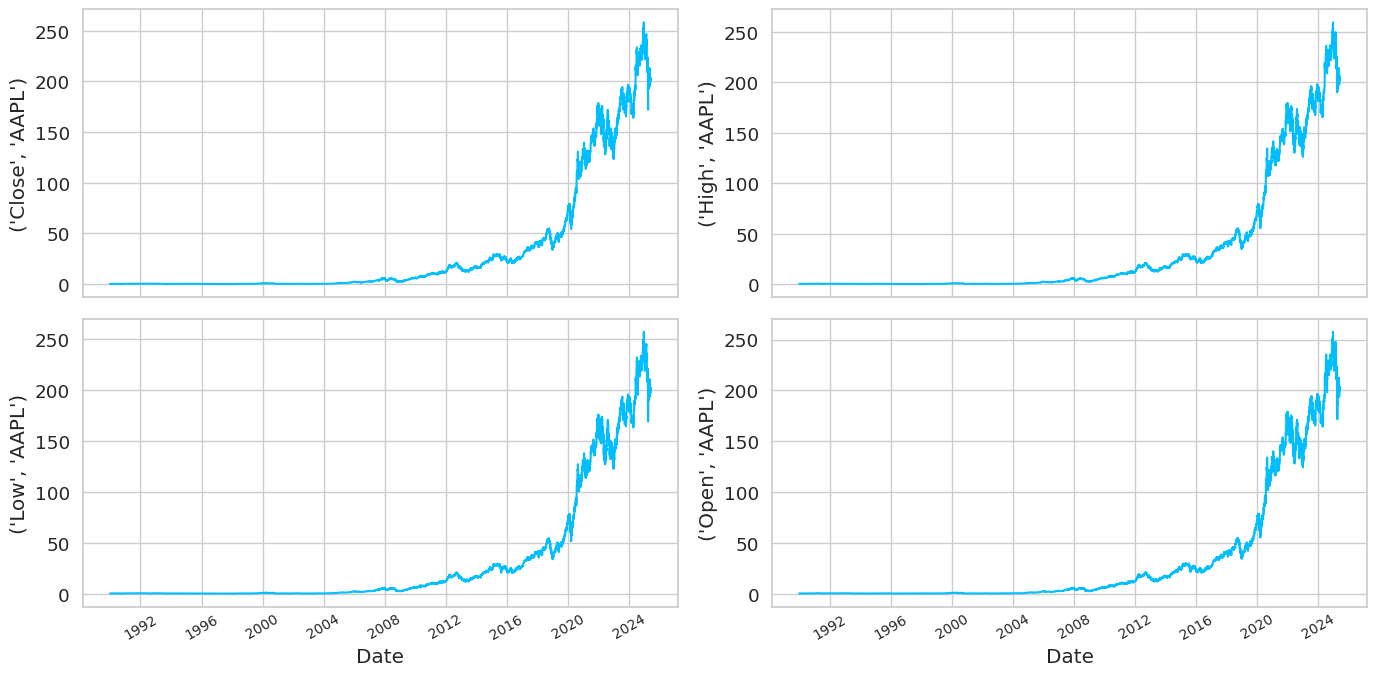

In [5]:
import matplotlib.dates as mdates

def data_plot(df):
    # Plot line charts
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

# Plot the data
data_plot(df)

In [6]:
import math
from sklearn.preprocessing import MinMaxScaler

# Train test split
training_data_len = math.ceil(len(df) * .8)
print(training_data_len)

# Splitting the dataset
train_data = df[:training_data_len]
test_data = df[training_data_len:]
print("type of train_data = ", type(train_data))
print("train_data.shape = ", train_data.shape)
print("type of test_data = ", type(test_data))
print("test_data.shape = ", test_data.shape)

# Selecting Open Price values
# dataset_train = train_data.iloc[:,3:4].values
dataset_train = train_data["Open"].values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print("dataset_train type = ", type(dataset_train.shape))
print("dataset_train.shape = ", dataset_train.shape)

# Selecting Open Price values
# dataset_test = test_data.iloc[:,3:4].values
dataset_test = test_data["Open"].values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print("dataset_test type = ", type(dataset_test.shape))
print("dataset_test.shape = ", dataset_test.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print("scaled_train type = ", type(scaled_train))
print("scaled_train.shape = ", scaled_train.shape)
print("scaled_train[:5] = ")
print(scaled_train[:5])

# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print("scaled_test type = ", type(scaled_test))
print("scaled_test.shape = ", scaled_test.shape)
print("scaled_test[:5] = ")
print(scaled_test[:5])

7140
type of train_data =  <class 'pandas.core.frame.DataFrame'>
train_data.shape =  (7140, 5)
type of test_data =  <class 'pandas.core.frame.DataFrame'>
test_data.shape =  (1784, 5)
dataset_train type =  <class 'tuple'>
dataset_train.shape =  (7140, 1)
dataset_test type =  <class 'tuple'>
dataset_test.shape =  (1784, 1)
scaled_train type =  <class 'numpy.ndarray'>
scaled_train.shape =  (7140, 1)
scaled_train[:5] = 
[[0.00351095]
 [0.00396066]
 [0.00400154]
 [0.00391978]
 [0.00387888]]
scaled_test type =  <class 'numpy.ndarray'>
scaled_test.shape =  (1784, 1)
scaled_test[:5] = 
[[0.03201232]
 [0.0345137 ]
 [0.04182763]
 [0.04162712]
 [0.04327352]]


In [7]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print("X_train.shape = ", X_train.shape)
print("y_train.shape = ", y_train.shape)

# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print("X_test.shape = ", X_test.shape)
print("y_test.shape = ", y_test.shape)

X_train.shape =  torch.Size([7090, 50, 1])
y_train.shape =  torch.Size([7090, 1])
X_test.shape =  torch.Size([1754, 30, 1])
y_test.shape =  torch.Size([1754, 1])


In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device = ", device)

input_size = 1
# num_layers = 3  # Increased number of layers
# hidden_size = 128  # Increased number of hidden units
num_layers = 2  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

model = LSTMModel(input_size, hidden_size, num_layers, dropout, output_size).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

device =  cpu


In [13]:
batch_size = 32  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/100] - Training Loss: 0.0001, Test Loss: 0.0002
Epoch [20/100] - Training Loss: 0.0001, Test Loss: 0.0005
Epoch [30/100] - Training Loss: 0.0001, Test Loss: 0.0002
Epoch [40/100] - Training Loss: 0.0001, Test Loss: 0.0002
Epoch [50/100] - Training Loss: 0.0001, Test Loss: 0.0003
Epoch [60/100] - Training Loss: 0.0001, Test Loss: 0.0002
Epoch [70/100] - Training Loss: 0.0001, Test Loss: 0.0003
Epoch [80/100] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [90/100] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [100/100] - Training Loss: 0.0000, Test Loss: 0.0002


historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor shape =  torch.Size([1, 30, 1])
historical_data shape =  (30,)
historical_data_tensor 

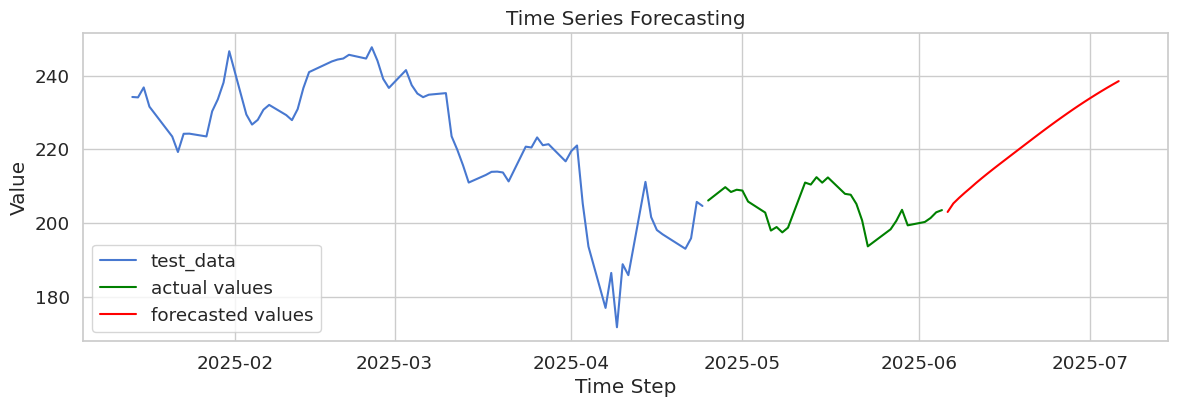

RMSE: 0.0150
R² Score: 0.9968


In [14]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        print("historical_data shape = ", historical_data.shape)
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        print("historical_data_tensor shape = ", historical_data_tensor.shape)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1) # roll[i-1] = historical_data[i]
        historical_data[-1] = predicted_value # roll[last] = predicted_value

last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

print("type of historical_data = ", type(historical_data))
print("historical_data shape = ", historical_data.shape)
print("type of test_data = ", type(test_data))
print("test_data shape = ", test_data.shape)
print("type of test_data[\"Open\"][-1:] = ", type(test_data["Open"][-1:]))
print("test_data[\"Open\"][-1:] shape = ", test_data["Open"][-1:].shape)
print("type of forecasted_values = ", type(forecasted_values))
print("np.array(forecasted_values) shape = ", np.array(forecasted_values).shape)
print("type of scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)) = ", type(scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))))
print("scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)) shape = ", scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).shape)
print("")
print("test_data.index[-100:] = ")
print(test_data.index[-100:])
print("test_data.index[-30:] = ")
print(test_data.index[-30:])
print("test_data[\"Open\"][-100:] = ")
print(test_data["Open"][-100:])
print("test_data[\"Open\"][-30:] = ")
print(test_data["Open"][-30:])

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:-30], test_data["Open"][-100:-30], label="test_data", color="b")
plt.plot(test_data.index[-30:-1], test_data["Open"][-30:-1], label='actual values', color='green')
plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data["Open"][-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))]), label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')